# Tensorflow Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='white', font_scale=1.5, palette='Set1')
%matplotlib inline

In [2]:
# The class column denotes authenticity of the bank note.
# 1 means authentic, and 0 means counterfeit.
notes = pd.read_csv('bank_note_data.csv', header=0)
display(notes.info(), notes.head(), notes.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
Image.Var     1372 non-null float64
Image.Skew    1372 non-null float64
Image.Curt    1372 non-null float64
Entropy       1372 non-null float64
Class         1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


None

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


,Image.Var,Image.Skew,Image.Curt,Entropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


[Text(0, 0, 'Counterfeit'), Text(0, 0, 'Authentic')]

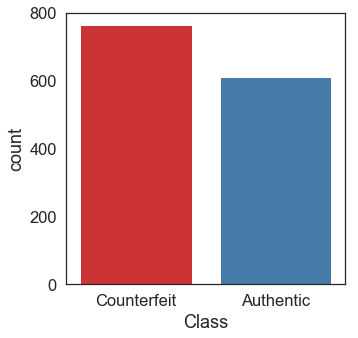

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(data=notes, x='Class', tick_label=['Counterfeit', 'Authetic'])
ax.set_xticklabels(['Counterfeit', 'Authentic'])

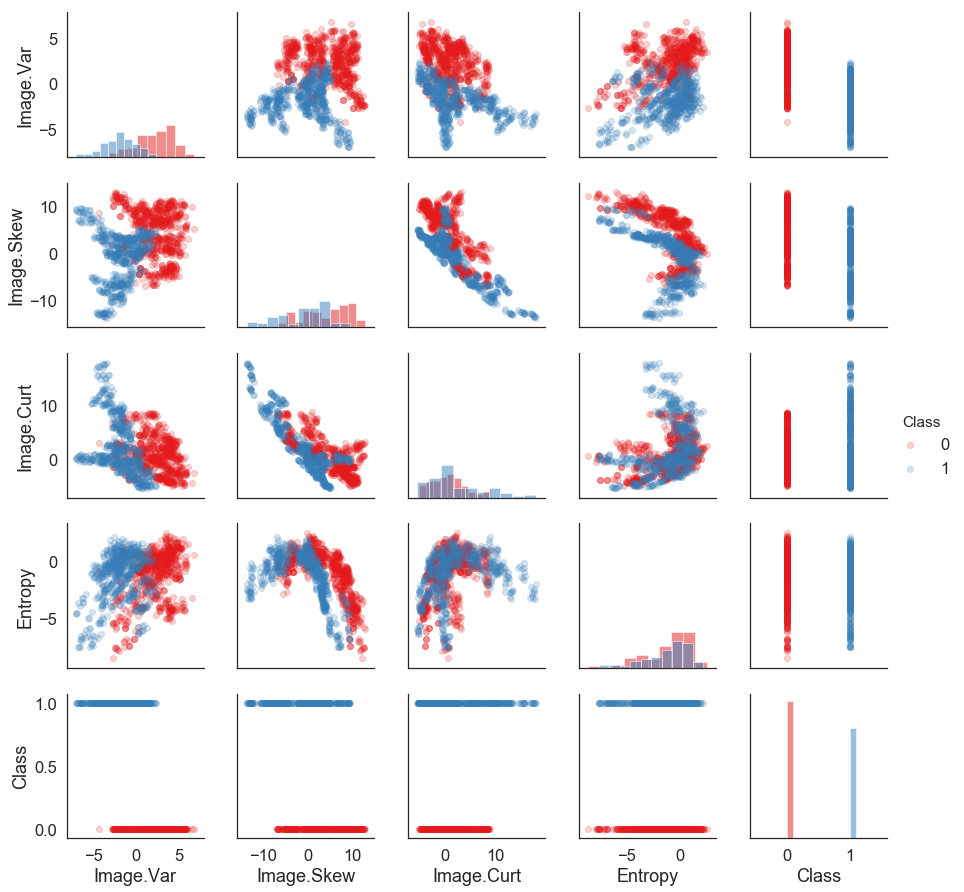

In [4]:
g = sns.PairGrid(notes, hue='Class')
g = g.map_diag(plt.hist, alpha=0.5) # Using KDE results in an error.
g = g.map_offdiag(plt.scatter, alpha=0.2)
g = g.add_legend()

In [5]:
scaler = StandardScaler()
scaler.fit(notes.drop('Class', axis=1))
scaled_features = pd.DataFrame(scaler.transform(notes.drop('Class', axis=1)), columns=notes.columns[:-1])
scaled_features.head()

,Image.Var,Image.Skew,Image.Curt,Entropy
0,1.121806,1.149455,-0.975970,0.354561
1,1.447066,1.064453,-0.895036,-0.128767
2,1.207810,-0.777352,0.122218,0.618073
3,1.063742,1.295478,-1.255397,-1.144029
4,-0.036772,-1.087038,0.736730,0.096587


In [6]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, notes['Class'], test_size=0.3)

In [7]:
feature_columns = [tf.feature_column.numeric_column(c) for c in scaled_features.columns]
feature_columns

[_NumericColumn(key='Image.Var', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Image.Skew', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Image.Curt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Entropy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [8]:
train_input_function = tf.estimator.inputs.pandas_input_fn(
    x = X_train,
    y = y_train,
    batch_size = 20,
    shuffle = True)

classifier = tf.estimator.DNNClassifier(
    hidden_units = [10, 20, 10],
    n_classes = 2,
    feature_columns = feature_columns)

classifier.train(input_fn=train_input_function, steps=500)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ozbon\\AppData\\Local\\Temp\\tmpoko1goc9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001472F768E80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for up

In [9]:
predict_input_function = tf.estimator.inputs.pandas_input_fn(
    x = X_test,
    batch_size = len(X_test),
    shuffle = False)

verbose_predictions = classifier.predict(input_fn=predict_input_function)
terse_predictions = [p['class_ids'][0] for p in verbose_predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ozbon\AppData\Local\Temp\tmpoko1goc9\model.ckpt-48
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [10]:
print(confusion_matrix(y_test, terse_predictions))
print(classification_report(y_test, terse_predictions))

[[231   3]
 [  0 178]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       234
           1       0.98      1.00      0.99       178

   micro avg       0.99      0.99      0.99       412
   macro avg       0.99      0.99      0.99       412
weighted avg       0.99      0.99      0.99       412



# Random Forest Comparison

In [11]:
rfc = RandomForestClassifier(n_estimators=1000, verbose=1)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_predictions))
print(classification_report(y_test, rfc_predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[231   3]
 [  0 178]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       234
           1       0.98      1.00      0.99       178

   micro avg       0.99      0.99      0.99       412
   macro avg       0.99      0.99      0.99       412
weighted avg       0.99      0.99      0.99       412



[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
